In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install --no-cache-dir -q transformers datasets torch scikit-learn pandas matplotlib seaborn accelerate

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
print(f"Transformers version: {transformers.__version__}")

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"GPU: {torch.cuda.device_count()} x {torch.cuda.get_device_name(0)}")

2025-11-11 19:01:57.511996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762887717.681471      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762887717.727297      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Transformers version: 4.53.3
GPU: 2 x Tesla T4


In [4]:
# Cell 2
path = "/kaggle/input/customer-feedback-dataset/sentiment-analysis.csv"

data = []
with open(path, 'r', encoding='utf-8') as f:
    lines = f.readlines()[1:]  # Skip header

for line in lines:
    line = line.strip()
    if not line: continue
    parts = line.split(',', 2)
    if len(parts) < 3: continue
    text = parts[0].strip().strip('"')
    sentiment = parts[1].strip()
    data.append({"Text": text, "Sentiment": sentiment})

df = pd.DataFrame(data)
df = df.dropna().reset_index(drop=True)

df['label'] = df['Sentiment'].map({'Positive': 2, 'Neutral': 1, 'Negative': 0})
df = df[df['label'].notna()].reset_index(drop=True)

print(f"Loaded: {len(df)} samples")
print(df.head())

Loaded: 96 samples
                                               Text Sentiment  label
0                              I love this product!  Positive      2
1                         The service was terrible.  Negative      0
2                            This movie is amazing!  Positive      2
3  I'm so disappointed with their customer support.  Negative      0
4                Just had the best meal of my life!  Positive      2


In [5]:
# Cell 3
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

Train: 76, Test: 20


In [7]:
# Cell 4
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['Text'], padding="max_length", truncation=True, max_length=128)

train_ds = Dataset.from_pandas(train_df[['Text', 'label']])
test_ds = Dataset.from_pandas(test_df[['Text', 'label']])

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds = train_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

# Remove extra columns
train_ds = train_ds.remove_columns(["Text"])
test_ds = test_ds.remove_columns(["Text"])

# Remove token_type_ids if present (BERT sometimes adds)
if 'token_type_ids' in train_ds.column_names:
    train_ds = train_ds.remove_columns(["token_type_ids"])
if 'token_type_ids' in test_ds.column_names:
    test_ds = test_ds.remove_columns(["token_type_ids"])

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [8]:
# Cell 5
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
# Cell 6
def compute_metrics(eval_pred):
    print("Computing metrics...")  
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'eval_f1': f1}

In [10]:
# Cell 7
training_args = TrainingArguments(
    output_dir='./bert-results',
    num_train_epochs=20,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False, 
    fp16=True,
    dataloader_num_workers=2,
    report_to="none",
    remove_unused_columns=False,
    prediction_loss_only=False,
    save_total_limit=1,
)

In [11]:
# Cell 8
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

print("Training Start...")
trainer.train()

Training Start...


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,1.128736,0.390323,0.550000
2,No log,1.117753,0.390323,0.550000
3,No log,1.099031,0.390323,0.550000
4,No log,1.072420,0.390323,0.550000
5,1.122300,1.037356,0.390323,0.550000
6,1.122300,0.993044,0.390323,0.550000
7,1.122300,0.940079,0.390323,0.550000
8,1.122300,0.870054,0.493333,0.600000
9,1.122300,0.797055,0.580878,0.650000
10,0.882900,0.706943,0.725071,0.750000


Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...
Computing metrics...


TrainOutput(global_step=40, training_loss=0.7264669716358185, metrics={'train_runtime': 81.8823, 'train_samples_per_second': 18.563, 'train_steps_per_second': 0.489, 'total_flos': 99983098736640.0, 'train_loss': 0.7264669716358185, 'epoch': 20.0})

Computing metrics...
Final Metrics: {'eval_f1': 1.0, 'eval_loss': 0.22265644371509552, 'eval_accuracy': 1.0, 'eval_runtime': 0.2635, 'eval_samples_per_second': 75.904, 'eval_steps_per_second': 3.795, 'epoch': 20.0}
Computing metrics...
Classes in test set: [0, 2] → ['Negative', 'Positive']


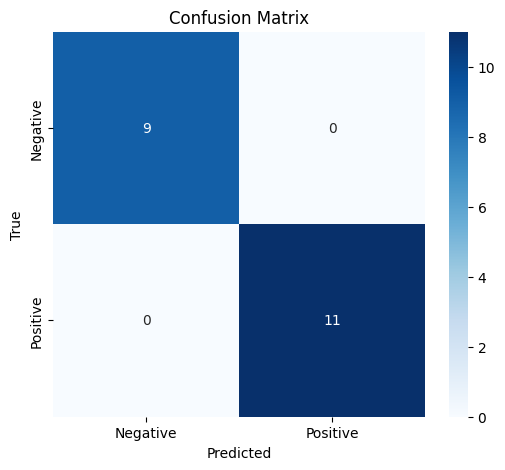


Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         9
    Positive       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [12]:
# Cell 9:
eval = trainer.evaluate()
print("Final Metrics:", eval)

preds = trainer.predict(test_ds)
pred_labels = np.argmax(preds.predictions, axis=-1)
true_labels = preds.label_ids

unique_labels = sorted(set(true_labels))
label_names = ['Negative', 'Neutral', 'Positive']
dynamic_names = [label_names[i] for i in unique_labels]

print(f"Classes in test set: {unique_labels} → {dynamic_names}")

cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dynamic_names,
            yticklabels=dynamic_names)
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, 
                          labels=unique_labels,
                          target_names=dynamic_names,
                          zero_division=0))

In [13]:
# Cell 10
id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():  # YE SAHI HAI
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=-1).item()
    return id2label.get(pred, "Unknown")


examples = ["I love it!", "Terrible!", "It's okay", "Great product", "Battery dies fast","love","disappointed"]
print("\nExample Predictions:")
for t in examples:
    print(f"→ '{t}' → {predict(t)}")


Example Predictions:
→ 'I love it!' → Positive
→ 'Terrible!' → Positive
→ 'It's okay' → Positive
→ 'Great product' → Positive
→ 'Battery dies fast' → Positive
→ 'love' → Positive
→ 'disappointed' → Positive
